In [2]:
import ee
import rioxarray as rxr
import pandas as pd

In [ ]:
ee.Authenticate()
ee.Initialize()

In [4]:
class Google_earth_engine: # Rode essa célula
    def __init__(self,time_start,
                 time_end,
                 coordinates,
                 name_folder_to_save:str,
                 name_file=None,
                 img_collection='ECMWF/ERA5_LAND/DAILY_AGGR',
                 var_select='temperature_2m_max',
                 scale_factor=10000,
                 ee=ee):
        '''
        time_start: insert the first data

        time_end: insert the last data

        coordinates: west, south, east, north ex: (-54.0, -25.0, -45.0, -15.0)
        
        name_folder_to_save: intuitive name ex: 'EE_files'
        '''
        self.time_start = time_start
        self.time_end = time_end
        self.coordinates = coordinates
        self.name_folder_to_save = name_folder_to_save
        self.img_collection = img_collection
        self.var_select = var_select
        self.name_file = name_file
        self.scale_factor = scale_factor
        self.ee = ee
    def Download_files_GEE(self):
        # Loading your coletions of data
        region =  self.ee.Geometry.BBox(*self.coordinates)
        collection = self.ee.ImageCollection(self.img_collection) \
            .filterDate(self.time_start, self.time_end) \
            .filterBounds(region) \
            .select(self.var_select)
    
        # Sorting in time
        collection = collection.sort('system:time_start')
        def format_band(img):
            date_str = self.ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
            return img.rename([date_str])
        # mergin collections
        stacked = collection.map(format_band).toBands().clip(region)
        # download your files to Google drive
        nm_file = None
        if self.name_file is None: nm_file = self.var_select
        else: nm_file = self.name_file
        try:
            task = self.ee.batch.Export.image.toDrive(
            image=stacked,
            description=nm_file,
            folder=self.name_folder_to_save,
            fileNamePrefix=nm_file, 
            region=region,
            scale=self.scale_factor,
            crs='EPSG:4326',
            maxPixels=1e13
            )
            task.start()
        except Exception as error:
            print(f'Erro em {error}')
def Organize_tiff_file(ds):
    ds = ds.drop_vars('spatial_ref').rename({'x':'longitude','y':'latitude','band':'time'})
    ds.name = 'temperature_2m_max'
    long_name_dates = ds.attrs['long_name']
    date_strings = [d.split('_')[1] for d in long_name_dates]
    dates = pd.to_datetime(date_strings)
    ds = ds-273.15
    ds['time'] = dates
    ds.attrs['long_name'] = "Daily Maximum 2m Temperature"
    return ds


A função abaixo irá baixar os arquivos e salvar na pasta selecionada (NO google drive).

In [ ]:
Gee = Google_earth_engine(time_start='2020-01-01',time_end='2020-02-01',coordinates=(-54.0, -25.0, -45.0, -15.0),name_folder_to_save='Pasta_files_GEE',ee=ee)
Gee.Download_files_GEE()

Após baixar o arquivo da pasta que você selecionou no Google Drive EX: Pasta_files_GEE

Nesta pasta obtemos um arquivo .tif

Acima criamos uma função para reorganizar o arquivo e também já convertemos em graus celsius. 

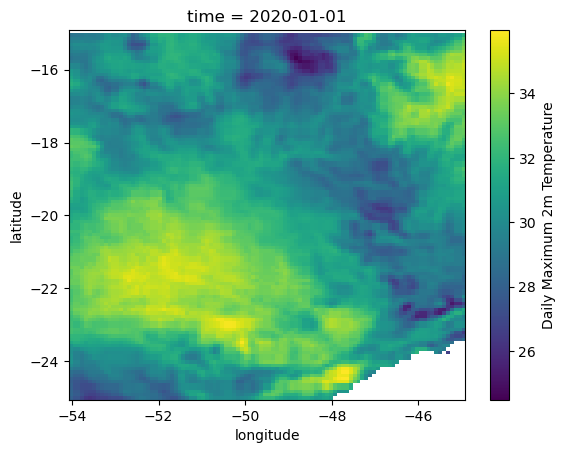

In [5]:
geotiff_path = 'temperature_2m_max.tif' 
ds = rxr.open_rasterio(geotiff_path)
ds_new = Organize_tiff_file(ds)
ds_new.isel(time=0).plot()

In [6]:
ds_new.to_netcdf('tmax_era5-land.nc')